In [1]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy
from scipy.linalg import pinv
import pandas as pd

import itertools
import scipy.stats

import time

import warnings
warnings.filterwarnings('ignore')

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# import plotly.graph_objs as go

from sklearn.preprocessing import StandardScaler

# Data

In [3]:
df = pd.read_csv('data/minist_train.csv')

df_sample = df.sample(10000)

y = df_sample[df_sample.columns[0]]
X= df_sample[df_sample.columns[1:]]

# split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dimensionality Reduction

## Feature Selection using Trees

In [4]:
etc = ExtraTreesClassifier(n_estimators = 100)
etc = etc.fit(X,y)
model = SelectFromModel(etc, prefit=True)
X_Trees = model.transform(X)

# Trees with Clustering

In [5]:
k = 7
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit_transform(X_Trees)

array([[1912.98549754, 1852.44941506, 1875.6576881 , ..., 1941.59340441,
        1820.63501757, 1997.52766396],
       [1576.24127051, 2025.33588408, 1882.72114385, ..., 1845.55508952,
        2149.95234761, 1529.05171051],
       [1915.96027258, 1940.97488933, 1716.08830629, ..., 1952.85926649,
        2116.67731595, 2087.00591822],
       ...,
       [1673.67005124, 1759.83636943, 1831.75604043, ..., 1864.68098278,
        2250.50326689, 1664.75477254],
       [1597.86864828, 1793.85313356, 2091.49063064, ..., 1867.4598203 ,
        2298.37025028, 1762.28829702],
       [1744.76779473, 1451.18291203, 1732.36557423, ..., 1617.85922729,
        2106.79370914, 1575.04705524]])

In [6]:
X_KMeans = np.append(X_Trees, k_means_clustering.fit_transform(X_Trees), 1)
X_KMeans_train, X_KMeans_test, y_KMeans_train, y_KMeans_test = train_test_split(X_KMeans, y, test_size=0.3, random_state=42)

In [7]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_KMeans_train, y_KMeans_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_KMeans_test, classifier_neural_network_best.predict(X_KMeans_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 100.0, 'hidden_layer_sizes': 18}
Time to train: 40946.196116924286
Accuracy for best neural network: 0.8963333333333333
Time to infer: 0.0052187442779541016


In [8]:
confusion_matrix(y_KMeans_test, classifier_neural_network_best.predict(X_KMeans_test))

array([[276,   0,   8,   0,   1,   5,   3,   0,   3,   4],
       [  0, 303,   2,   1,   0,   1,   2,   2,  10,   3],
       [  2,   3, 277,   1,   6,   0,   7,   3,   4,  11],
       [  0,   1,   7, 225,   2,  10,   6,   4,  14,   6],
       [  0,   0,   3,   0, 281,   0,   1,   0,   1,  14],
       [  3,   1,  10,   4,  10, 206,   3,   5,   6,   8],
       [  0,   0,   2,   0,   4,   2, 296,   0,   0,   0],
       [  0,   1,   8,   1,   6,   0,   0, 268,   1,  17],
       [  0,   4,   6,   3,   5,   5,   2,   0, 247,  11],
       [  2,   0,   2,   3,  14,   1,   0,   6,   4, 310]])

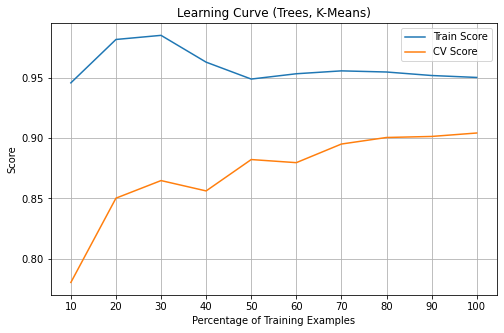

In [9]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_KMeans_train, y_KMeans_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Trees, K-Means)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_exp5_Trees_learning_curve_kmeans.png')
plt.show()

## EM (GMM)

In [10]:
gmm = mixture.GaussianMixture(n_components=7, covariance_type='full')
gmm.fit(X_Trees)
gmm.predict_proba(X_Trees)

array([[7.79307632e-019, 0.00000000e+000, 1.00000000e+000, ...,
        1.52880874e-116, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.22065095e-159, ...,
        0.00000000e+000, 8.41816306e-150, 1.00000000e+000],
       [1.00000000e+000, 0.00000000e+000, 4.61102231e-158, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 2.47140714e-112, ...,
        0.00000000e+000, 1.19263959e-127, 1.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 2.04529911e-091, ...,
        3.08258489e-227, 6.16382254e-148, 1.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.42833405e-153, ...,
        0.00000000e+000, 5.80545198e-159, 1.00000000e+000]])

In [11]:
X_GMM = np.append(X_Trees, gmm.predict_proba(X_Trees), 1)
X_GMM_train, X_GMM_test, y_GMM_train, y_GMM_test = train_test_split(X_GMM, y, test_size=0.3, random_state=42)

In [12]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_GMM_train, y_GMM_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_GMM_test, classifier_neural_network_best.predict(X_GMM_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 100.0, 'hidden_layer_sizes': 22}
Time to train: 11712.34471988678
Accuracy for best neural network: 0.931
Time to infer: 0.006189107894897461


In [13]:
confusion_matrix(y_GMM_test, classifier_neural_network_best.predict(X_GMM_test))

array([[294,   0,   0,   0,   0,   2,   2,   0,   0,   2],
       [  0, 316,   2,   1,   1,   0,   1,   1,   2,   0],
       [  7,   6, 291,   1,   2,   1,   3,   1,   2,   0],
       [  2,   2,   8, 240,   0,   8,   4,   2,   5,   4],
       [  0,   0,   4,   0, 280,   1,   7,   0,   1,   7],
       [  5,   0,   2,  10,   1, 229,   6,   1,   0,   2],
       [  1,   0,   0,   0,   0,   0, 303,   0,   0,   0],
       [  1,   6,   6,   0,   4,   0,   0, 282,   0,   3],
       [  4,   4,   3,   6,   1,   8,   4,   1, 250,   2],
       [  3,   0,   0,   7,  13,   3,   1,   6,   1, 308]])

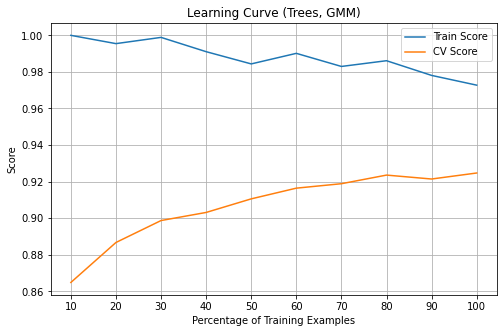

In [14]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_GMM_train, y_GMM_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Trees, GMM)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_exp5_Trees_learning_curve_gmm.png')
plt.show()